# Liver Model Construction: Notebook-Glycogenolysis

## Setup workflow

### Import packages

In [1]:
import os
import re
import warnings
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

MASSpy version: 0.1.1


## Set paths and constants

In [2]:
seed = int(4)
#increase number of models from before
n_models = 3

mass_config = MassConfiguration()
mass_config.solver = "cplex"

### Directory paths

In [3]:
model_dir = os.path.abspath("../models")
maps_dir = os.path.abspath("../maps")
data_dir = os.path.abspath("../data")

In [4]:
# model_dir = os.path.abspath(".../MASSliver/models")
# maps_dir = os.path.abspath(".../MASSliver/models/maps")
# data_dir = os.path.abspath(".../MASSliver/data/interim")

In [5]:
# Allow Escher to close without pop-up
escher.rc['never_ask_before_quit'] = True


### Load COBRA model

In [6]:
#load core model
core_model=load_json_cobra_model(filename=os.path.join(model_dir,"CoreModel.json"))
core_model

Name,None
Memory address,0x01f485b982e0
Number of metabolites,178
Number of reactions,187
Number of groups,0
Objective expression,1.0*ATPM - 1.0*ATPM_reverse_5b752
Compartments,"m, i, c, r,"


In [7]:
#create trial model
trial = Model('Smaller Glycogenolysis') 
trial

Name,Smaller Glycogenolysis
Memory address,0x01f485e9caf0
Number of metabolites,0
Number of reactions,0
Number of groups,0
Objective expression,0
Compartments,


In [8]:
#load Recon3D
R3D=load_json_cobra_model(filename=os.path.join(model_dir,"Recon3D.json"))

In [9]:
# ## adding reactions from glycogenloysis 
# gly=load_json_cobra_model(filename=os.path.join(model_dir,"Glycogenolysis.json"))
# r_list=[
   
# #     'EX_pyr_e',
# #     'EX_lac__L_e'  
# ]
# for rid in r_list:
#     reaction = core_model.reactions.get_by_id(rid)
#     trial.add_reactions([reaction])

In [10]:
#add all reactions to a list
R3D_list=[
    'HEX1',
    'PGI', 
    'PFK',
    'FBP',
    'FBA',
    'TPI',
    'GAPD',
    'PGK',
    'PGM',
    'ENO',
    'PYK',
    'PYRt2m',
    'PCm',
    'PEPCKm',
    'LDH_L',
    'G6PPer',
    'G6Pter',
    'GLCter',
    'H2Oter',
    'PIter',
    'H2Ot',
    'PIt',
    'EX_glc__D_e',
    'GLCt1',
    'Ht',
    'L_LACt2r', #lactose transport between lactate in cytosol and extracellular 
    'PYRt2' #pyruvate transport between pyruvate in cytosol and extracellular 
]
#add reactions from R3D to trial model
for rid in R3D_list:
    reaction = R3D.reactions.get_by_id(rid)
    trial.add_reactions([reaction])
    
#add reactions from core to trial model
core_list=['PEPtm']
for rid in core_list:
    reaction = core_model.reactions.get_by_id(rid)
    trial.add_reactions([reaction])

In [11]:
#get metabolites for sinks/exchanges
pyrc=R3D.metabolites.get_by_id('pyr_c')
pyrm=R3D.metabolites.get_by_id('pyr_m')
hco3=R3D.metabolites.get_by_id('hco3_m')
co2=R3D.metabolites.get_by_id('co2_m')
gtp=R3D.metabolites.get_by_id('gtp_m')
gdp=R3D.metabolites.get_by_id('gdp_m')

atpc=R3D.metabolites.get_by_id('atp_c')
atpm=R3D.metabolites.get_by_id('atp_m')
adp=R3D.metabolites.get_by_id('adp_c')
h2o=R3D.metabolites.get_by_id('h2o_e')
pie=R3D.metabolites.get_by_id('pi_e')
pim=R3D.metabolites.get_by_id('pi_m')
he=R3D.metabolites.get_by_id('h_e')
hm=R3D.metabolites.get_by_id('h_m')
nadh=R3D.metabolites.get_by_id('nadh_c')
nad=R3D.metabolites.get_by_id('nad_c')


pyre = R3D.metabolites.get_by_id("pyr_e")
lace = R3D.metabolites.get_by_id("lac__L_e")

In [12]:
# create sink/exchange reaction
trial.add_boundary(atpc, type="sink")
trial.add_boundary(gtp, type="sink")
trial.add_boundary(gdp, type="sink")
trial.add_boundary(atpm, type="sink")
trial.add_boundary(pyrm, type="sink")
trial.add_boundary(pyrc, type="sink")
trial.add_boundary(nadh, type="sink")
trial.add_boundary(nad, type="sink")
trial.add_boundary(adp, type="sink")
trial.add_boundary(hm, type="sink")
trial.add_boundary(hco3, type="sink")
trial.add_boundary(co2, type="sink")
trial.add_boundary(pim, type="sink")

#why are these exchanges
trial.add_boundary(h2o, type="exchange")
trial.add_boundary(pie, type="exchange")
trial.add_boundary(he, type="exchange")
trial.add_boundary(pyre, type="exchange")
trial.add_boundary(lace, type="exchange")

Reaction identifier,EX_lac__L_e
Name,L-Lactate exchange
Memory address,0x01f486664910
Stoichiometry,lac__L_e <=> L-Lactate <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [13]:
trial.reactions

[<Reaction HEX1 at 0x1f48d97da30>,
 <Reaction PGI at 0x1f48d742a60>,
 <Reaction PFK at 0x1f48bcffdf0>,
 <Reaction FBP at 0x1f48d940370>,
 <Reaction FBA at 0x1f48d726ee0>,
 <Reaction TPI at 0x1f48bcc8220>,
 <Reaction GAPD at 0x1f48d940eb0>,
 <Reaction PGK at 0x1f48d742c70>,
 <Reaction PGM at 0x1f48bc3caf0>,
 <Reaction ENO at 0x1f48d6d7eb0>,
 <Reaction PYK at 0x1f48bd1c7f0>,
 <Reaction PYRt2m at 0x1f48e936bb0>,
 <Reaction PCm at 0x1f48e874fd0>,
 <Reaction PEPCKm at 0x1f48e893c70>,
 <Reaction LDH_L at 0x1f48d7c1460>,
 <Reaction G6PPer at 0x1f48938f1f0>,
 <Reaction G6Pter at 0x1f48e412490>,
 <Reaction GLCter at 0x1f4894357c0>,
 <Reaction H2Oter at 0x1f48948be50>,
 <Reaction PIter at 0x1f4897cbbb0>,
 <Reaction H2Ot at 0x1f48bc1e490>,
 <Reaction PIt at 0x1f48ac72af0>,
 <Reaction EX_glc__D_e at 0x1f48c7de490>,
 <Reaction GLCt1 at 0x1f48e4abaf0>,
 <Reaction Ht at 0x1f48d6d7430>,
 <Reaction L_LACt2r at 0x1f48d97ddc0>,
 <Reaction PYRt2 at 0x1f48bd3ccd0>,
 <Reaction PEPtm at 0x1f4860b2e50>,
 <Rea

## View Escher map

In [14]:
#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir, ".".join((
            "Glycogenolysis", "map", "json"))
    ),
    highlight_missing=True)

escher_builder


Builder(highlight_missing=True, never_ask_before_quit=True)

### Loading Measured Fluxes

In [17]:
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [18]:
#define data sheet as latest data sheet
data_sheet=os.path.join(data_dir,"3.7-ma-data-collection.xlsx")

flux_df = load_data(
    filepath=data_sheet,
    sheet_name="Fluxes").drop("Fasting Time", axis=1).drop("Additional Notes", axis=1)
flux_df = flux_df.dropna() #drops rows with NaN
flux_df


,Flux (mmol/gDW*hr)
ID,
G6PPer,0.001682
HEX1,0.000000
GLCt1,-0.001682
PGI,-0.002919
EX_glc__D_e,0.085498
FBP,0.002919
PFK,0.000000
FBA,-0.002919
GAPD,-0.002919


In [19]:
v_vars = []
v_data = []

# How much flux to allow through irreversible reaction pairs
# e.g, PFK/FBP & reverse_flux_percent = 0.1, raise both fluxes by 10% of non-zero flux value
reverse_flux_percent = 0.1
irreversible_enzyme_pairs = ["PFK", "FBP"]
irreversible_enzyme_pairs2 = ["HEX1", "G6PPer"]
irreversible_enzyme_pairs3 = ["PYK", "PEPCKm"]


In [20]:
for rid, flux in flux_df.itertuples():
    reaction = trial.reactions.get_by_id(rid)
    #reaction.bounds = (flux, flux)
    #set bounds for all boundary reactions 
    #uptake --> (-value, 1000)
    #secretion --> (-1000 --> value)
    #reversible --> (-1000,1000)
    if (rid == "EX_lac__L_e"): #uptake
#         pass
        reaction = trial.reactions.get_by_id(rid)
        reaction.bounds = (-0.084372,-0.084372) 
    if (rid == "EX_glc__L_c"): #secretion
        reaction = trial.reactions.get_by_id(rid)
        reaction.bounds = (0.085498214,0.085498214) ## restricting glucose  HEPATOKIN Supplemental 15 
    elif (rid == "EX_pyr_e"): #uptake
        reaction = trial.reactions.get_by_id(rid)
        reaction.bounds = (0, 1000) 
#     elif (rid == "SK_f6p_c"): 
#         reaction = trial.reactions.get_by_id(rid)
#         reaction.bounds = (-1000, 0)
#     elif (rid == "SK_g6p_c"): 
#         reaction = trial.reactions.get_by_id(rid)
#         reaction.bounds = (-1000, 0)
#     elif (rid == "EX_glygn2_c"): #uptake
#         reaction = core_model.reactions.get_by_id(rid)
#         reaction.bounds = (-1, 1000) 
    for irreversible_enzyme_pair in irreversible_enzyme_pairs:
        if rid in irreversible_enzyme_pair:
            flux1, flux2 = flux_df.loc[irreversible_enzyme_pairs, "Flux (mmol/gDW*hr)"].values
            if flux1 == 0:
                flux += reverse_flux_percent * flux2 # mmol*gDW^-1*hr^-1
            if flux2 == 0:
                flux += reverse_flux_percent * flux1 # mmol*gDW^-1*hr^-1
    for irreversible_enzyme_pair in irreversible_enzyme_pairs2:
        if rid in irreversible_enzyme_pair:
            flux3, flux4 = flux_df.loc[irreversible_enzyme_pairs2, "Flux (mmol/gDW*hr)"].values
            if flux3 == 0:
                flux += reverse_flux_percent * flux4 # mmol*gDW^-1*hr^-1
            if flux4 == 0:
                flux += reverse_flux_percent * flux3 # mmol*gDW^-1*hr^-1
                
    for irreversible_enzyme_pair in irreversible_enzyme_pairs3:
        if rid in irreversible_enzyme_pair:
            flux5, flux6 = flux_df.loc[irreversible_enzyme_pairs3, "Flux (mmol/gDW*hr)"].values
            if flux5 == 0:
                flux += reverse_flux_percent * flux6 # mmol*gDW^-1*hr^-1
            if flux6 == 0:
                flux += reverse_flux_percent * flux5 # mmol*gDW^-1*hr^-1
    #address irreversible enzyme pair boundary reactions if necessary

    print(rid, flux)

    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)

G6PPer 0.0018502083831
HEX1 0.00016820076210000002
GLCt1 -0.001682007621
PGI -0.002918552036
EX_glc__D_e 0.0854982138575
FBP 0.0032104072395999998
PFK 0.0002918552036
FBA -0.002918552036
GAPD -0.002918552036
PGK 0.002918552036
PGM 0.002918552036
ENO -0.002918552036
PYK 0.001950821624
PCm 0.004685044058
PEPCKm 0.00487705406
EX_pyr_e -0.0421858770764
EX_lac__L_e -0.0843718063796


In [21]:
# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)

F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
trial.objective = objective[0]
trial.objective_direction = "min"

flux_solution = trial.optimize()

In [22]:
# ab=pd.DataFrame(flux_solution.fluxes)
# ab.to_excel("output.xlsx")
flux_solution.fluxes

HEX1           0.001009
PGI            0.000000
PFK            0.001751
FBP            0.001751
FBA            0.000000
TPI            0.000000
GAPD           0.000000
PGK            0.000000
PGM            0.000000
ENO            0.000000
PYK            0.000000
PYRt2m         0.087132
PCm            0.000000
PEPCKm         0.000000
LDH_L          0.084372
G6PPer         0.001009
G6Pter         0.001009
GLCter        -0.001009
H2Oter         0.001009
PIter          0.001009
H2Ot           0.002760
PIt            0.002760
EX_glc__D_e    0.000000
GLCt1          0.000000
Ht            -0.084372
L_LACt2r       0.084372
PYRt2          0.000000
PEPtm          0.000000
SK_atp_c      -0.002760
SK_gtp_m       0.000000
SK_gdp_m      -0.000000
SK_atp_m      -0.000000
SK_pyr_m       0.087132
SK_pyr_c      -0.002760
SK_nadh_c      0.084372
SK_nad_c      -0.084372
SK_adp_c       0.002760
SK_h_m         0.087132
SK_hco3_m      0.000000
SK_co2_m      -0.000000
SK_pi_m       -0.000000
EX_h2o_e      -0

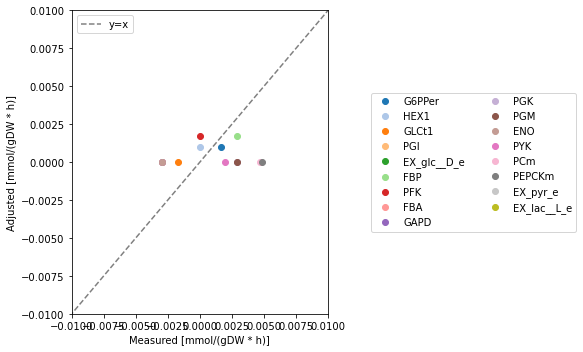

In [23]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_df["Flux (mmol/gDW*hr)"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.01,0.01), ylim=(-0.01, 0.01),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()
#check directionality 


## Create MASS model

In [ ]:
glycogenolysis = MassModel("Glycogenolysis", array_type='DataFrame', dtype=np.int64)
glycogenolysis

### Define reactions

In [ ]:
#add reactions one at a time
##G6PPer, HEX1, GLCt1, PGI

# EX_glc__D_e    0.001682

# SK_f6p_c      -0.001682
# SK_g6p_c       0.000000
# SK_atp_c      -0.000168
# SK_adp_c       0.000168
# EX_h2o_e      -0.001850
# EX_pi_e        0.001850
# EX_h_e         0.000168


reaction_list=[]
reaction_list = ['HEX1',
                 'PFK',
                 'FBP',
                 'FBA',
                 'TPI',
                 'GLCt1',
                 'G6Pter',
                 'G6PPer',
                 'GLCter',
#                  'EX_glc__D_e',
                'PGI',
                'H2Oter',
                'PIter',
                'H2Ot',
                'PIt',
                'Ht',
                'GAPD',
                'PGK',
                'PGM',
                'ENO',
                 'PEPtm',
                 'PEPCKm',
#                 #'LDH_L',
                 'PYK',
                 'PCm',
                 'PYRt2m'
                ]


In [ ]:
# Convert cobra.Reactions to mass.MassReactions
for rid in reaction_list:
    reaction = trial.reactions.get_by_id(rid)
    glycogenolysis.add_reactions([MassReaction(reaction)])

##  Set Fluxes

In [ ]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = glycogenolysis.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux * 1278.605 / 1000 
    # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

## Set Keqs

In [ ]:
# Load equilibrium constants
Keq_df = pd.read_excel(engine='openpyxl',
    io=data_sheet,
    sheet_name="Keqs",
    index_col=0).drop("Reference", axis=1).drop("Stoichiometry", axis=1).drop('Keq unit', axis=1)

Keq_df = Keq_df.dropna() #drops rows with NaN
Keq_df

In [ ]:
Keq_list =[]
#setting exchange constants as 1

transport= [
    'H2Oter',
    'PIter',
    'H2Ot',
    'PIt',
    'Ht',
    'GLCter',
    'G6Pter',
    'PYRt2m',
    'PEPtm'
]
for x in transport:
    a=glycogenolysis.reactions.get_by_id(x)
    a.Keq=1

glycogenolysis.reactions.G6PPer.Keq=1/0.278 ## value seems to be inverted

for rid, Keq in Keq_df.itertuples():
    if rid in reaction_list: 
        reaction = glycogenolysis.reactions.get_by_id(rid)
        reaction.Keq = Keq
        Keq_list.append(reaction.Keq)
        print("{0}: {1}".format(reaction.Keq_str, Keq))
glycogenolysis.reactions.G6PPer.Keq=1/0.278

## Obtain Concentrations

In [ ]:
compartment_finder_re = re.compile(r"\s*\[([A-Za-z])\]")
rateconst_re = re.compile(r"k_(\S*)_(fwd|rev)\Z")
bound_metabolites_re = re.compile(r"&|@|#")

In [ ]:
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [ ]:
# prefix_number_id('13dpg_c')

In [ ]:
for metabolite in glycogenolysis.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
glycogenolysis.repair()

In [ ]:
for metabolite in glycogenolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

In [ ]:
#Load Concentration Data
conc_df = load_data(
    filepath=data_sheet,
    sheet_name="Concentrations").drop("Concentration (mM)", axis=1)
conc_df = conc_df.drop("Additional Notes", axis=1)
conc_df = conc_df.dropna() #drops rows with NaN
conc_df

In [ ]:
# Fix identifiers in the dataframe
conc_df.index = [prefix_number_id(mid) for mid in conc_df.index]

In [ ]:
#Set Concentrations

metabolite_list = [
# HEX1    
                    'glc__D_c',
                    'g6p_c',
                    'adp_c',
                    'atp_c',
                    'h_c',
# GLCt1
                    'glc__D_e',

# #G6Pter
                    'g6p_r',

# #G6PPer , #GLCter
                    'h2o_r',
                    'glc__D_r',
                    'pi_r',
#  'PGI',
                    'f6p_c', 
# 'H2Oter',
                    'h2o_c',

# 'PIter',
                    'pi_r',
                    'pi_c',

#'H2Ot',
                    'h2o_e',
#'PIt',
                    'pi_e',

#'Ht'
                    'h_e'  ,
# PFK/ FBP
                    'fdp_c',
# FBA/TPI
                    'dhap_c',
                    'g3p_c',
# GAPD
                    'nad_c',
                    'nadh_c',
                    '13dpg_c',
#PGK
                    '3pg_c',
#PGM
                    '2pg_c',
#ENO
                    'pep_c',
#PYK
                    'pyr_c',
#PYRt2m #what should we do about h_i
                    'h_m',
                    'pyr_m',
#PCm
                    'hco3_m',
                    'pi_m',
                    'atp_m',
                    'adp_m',
                    'oaa_m',
#PEPCKm
                    'gtp_m',
                    'co2_m',
                    'gdp_m',
                    'pep_m'
#PEPtm
]

In [ ]:
met_list = []
for mid, name, conc in conc_df.itertuples():
    if mid in metabolite_list: 
        metabolite = glycogenolysis.metabolites.get_by_id(mid)
        metabolite.name = name
        
        metabolite.ic = conc #data sheet is in M units
        met_list.append(metabolite.ic)

for metabolite in glycogenolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

## Set H2O/H Constants

In [ ]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    "h_c",'h_e','h_m',
    'h2o_r','h2o_e',"h2o_c",
    "glc__D_e", "pi_e",'pi_m','pi_c'
    #remove h_i and h_m if not mitochondrial reactions
                  ]:
    metabolite = glycogenolysis.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [ ]:
for metabolite in [
    #'h_i',
    'h_m',
"h_c", 'h_e',
"h2o_c",'h2o_r','h2o_e' 
]:
    metabolite = glycogenolysis.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M
    
glycogenolysis.metabolites.glc__D_e.ic= 0 #setting extracellular glucose as 0 because no lactate rn
   
#plasma phsophate concentration to be equal to intracellular plasma concentration
glycogenolysis.metabolites.pi_e.ic=0.0064



In [ ]:
#Formulate QP minimization list for concentrations
## double check this?
conc_solver = ConcSolver(
    glycogenolysis, # bc only want metabolites in glycogenolysis 
    excluded_metabolites=[
        #'h_i','co2_m', 'gdp_m', 'gtp_m', 'hco3_m'
        "h_c",'h_e', 'h_m',
    'h2o_r','h2o_e',"h2o_c",
        "pi_e",
        "glc__D_e"
    ], excluded_reactions=["Ht", "H2Ot", "H2Oter",
                            'PIter',
                            'PIt',
                           'G6Pter',
                           'GLCter',
                           'GLCt1',
                           'PYRt2m',
                           'PEPtm'
                          ],
    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(glycogenolysis.fixed))
fixed_Keq_bounds=glycogenolysis.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

In [ ]:
conc_solution.concentrations

In [ ]:
for c in conc_solver.constraints:
    print(c)

In [ ]:
#Compare Results
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration(M)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(-0.001,0.02), ylim=(-0.001,0.02),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    glycogenolysis, conc_solution, concentrations=True, inplace=True);

## Sample Concentrations

In [ ]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(glycogenolysis.fixed),
    fixed_Keq_bounds=glycogenolysis.reactions.list_attr("Keq_str"))
for variable in conc_solver.variables:
    try:
        met = glycogenolysis.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=seed)
conc_samples.head()

## Set concentrations and balance models with pseudoreactions

In [ ]:
glycogenolysis.boundary_conditions['glc__D_b']=0.010482807 ##  initial condition of the metabolite in the model


In [ ]:
# glycogenolysis.steady_state_fluxes.values
glycogenolysis.update_S(array_type="DataFrame")

In [ ]:
# for r, v in glycogenolysis.steady_state_fluxes.items():
#      if not r.boundary:
#         print(r,v)
# for r, v in glycogenolysis.steady_state_fluxes.items():
#      if not (r.boundary or r== glycogenolysis.reactions.GLCter or r==glycogenolysis.reactions.PIter):
#             print(r,v)

In [ ]:
transport= [
#  'H2Oter',
    'PIter',
#      'H2Ot',
    'PIt',
#      'Ht',
    'GLCter',
     'G6Pter',
    'PYRt2m',
    'PEPtm'
]
for x in transport:
    a=glycogenolysis.reactions.get_by_id(x)
    a.kf=1e6

In [ ]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = glycogenolysis.copy()
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0 or new_model.metabolites.get_by_id(mid).compartment== "e": # to remove SK_glc__D_e
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)
        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)

        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items() 
                    if not (r.boundary or r== new_model.reactions.GLCter or r== new_model.reactions.PIter 
                           or r== new_model.reactions.G6Pter or r== new_model.reactions.PIt)},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            percs = new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not (r.boundary  or r== new_model.reactions.GLCter or r== new_model.reactions.PIter
                           or r== new_model.reactions.G6Pter or r== new_model.reactions.PIt)},
                update_reactions=False)
            print(percs)
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(len(models_for_ensemble)))
# print(models_for_ensemble)

In [ ]:
len(models_for_ensemble)

#### Ensure model is in steady state and export

In [ ]:
## determine imbalances in the reduced network
fluxes = np.array(list(glycogenolysis.steady_state_fluxes.values()))
imbalanced_metabolites = glycogenolysis.S.dot(fluxes)

# Iterate through metabolites
for mid, imbalance in imbalanced_metabolites.iteritems():
    # Ignore balanced metabolites
    if imbalance == 0 or glycogenolysis.metabolites.get_by_id(mid).compartment== "e": # to remove SK_glc__D_e:
        continue
    # Get metabolite object
    met = glycogenolysis.metabolites.get_by_id(mid)

    # Add boundary reactions for imbalanced metabolites
    boundary_type = "sink"    
    # Add boundary reaction with imbalance as flux value
    boundary_reaction = glycogenolysis.add_boundary(
        mid, boundary_type, boundary_condition=met.ic)

    boundary_reaction.Keq = 1
    if imbalance < 0:
        boundary_reaction.reverse_stoichiometry(inplace=True)
        imbalance = -imbalance

    boundary_reaction.kf = imbalance / met.ic
    boundary_reaction.steady_state_flux = imbalance
    try:
        # Update PERCs
            percs= glycogenolysis.calculate_PERCs(
            fluxes={
                r: v for r, v in glycogenolysis.steady_state_fluxes.items()
                if not (r.boundary  or r== glycogenolysis.reactions.GLCter or r== glycogenolysis.reactions.PIter
                           or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt)},
            update_reactions=True)
            print(percs)
    except:
        print("Negative PERCs for {0}".format(new_model.id))
        continue

In [ ]:
# glycogenolysis.reactions.EX_glc__D_e.kf= 1000
for reaction in glycogenolysis.reactions:
    print(reaction.id, reaction.kf)

In [ ]:
## balancing charges on reactions manually

glycogenolysis.metabolites.h_c.charge=1

glycogenolysis.metabolites.h_e.charge=1
# glycolysis.metabolites.h_c.charge=1
# glycolysis.metabolites.h_m.charge=1
# glycolysis.metabolites.h_i.charge=1
glycogenolysis.metabolites.pi_c.charge=-2
glycogenolysis.metabolites.pi_e.charge=-2
# glycolysis.metabolites.pi_m.charge=-2
glycogenolysis.metabolites.pi_r.charge=-2


In [ ]:
glycogenolysis.calculate_PERCs(fluxes={
                r: v for r, v in glycogenolysis.steady_state_fluxes.items()
                if not (r.boundary  or r== glycogenolysis.reactions.GLCter or r== glycogenolysis.reactions.PIter
                           or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt)}, update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in glycogenolysis.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

In [ ]:
#list(range(len
(list(model.genes))

#           )))

In [ ]:
for x in list(range(len(list(model.genes)))):
#     print(a)
    #a= model.genes[x]
    model.genes.remove(a)
    
print(list(model.genes))

In [ ]:
# Whether to print messages as loop occurs. 
verbose = False
# Ensure all models are simulated to a long time and that
# there are enough time points to determine if model reached steady state.
tfinal = 1e4

sim = Simulation(reference_model=models_for_ensemble[0], verbose=verbose)
sim.add_models(models_for_ensemble[1:], verbose=verbose, disable_safe_load=True)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

models_to_export = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in models_for_ensemble:
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " first attempt failed.")
        # First attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 10, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " second attempt failed.")
        # Second attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 100, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " third attempt failed. Eliminating model.")
        # Third attempt was not successful, eliminate the model
        sim.remove_models(models=model, verbose=verbose)

In [ ]:
models_for_ensemble = []
qcqa_model(glycogenolysis, parameters=True, concentrations=True,
          fluxes=True, superfluous=True, elemental=True)


In [ ]:
# range(len(glycogenolysis.genes))
for x in list(glycogenolysis.genes):
    glycogenolysis.genes.remove(x)
print(list(glycogenolysis.genes))



In [ ]:
###RUN THIS FOR TIME PROFILE
# Setup simulation object
sim = Simulation(glycogenolysis, verbose=False)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycogenolysis, time=(0, 1e10, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [ ]:
fig_1, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6));
(ax1, ax2) = axes.flatten()
L_FONT = {"size": "large"}
plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    plot_function="semilogx",
    xlabel="Time [hr]", ylabel="Concentration [M]",
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    plot_function="loglog",
    xlabel="Time [hr]", ylabel="Flux (mmol/gDW*hr)",
    title=("Flux Profile", L_FONT));
fig_1.tight_layout()

